<a href="https://colab.research.google.com/github/zhenbangt/aa228_final_project/blob/main/colab-testing-mccfr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# <a href='https://github.com/datamllab/rlcard'> <center> <img src='https://miro.medium.com/max/1000/1*_9abDpNTM9Cbsd2HEXYm9Q.png' width=500 class='center' /></a> 

## **Training CFR on Leduc Hold'em**
To show how we can use `step` and `step_back` to traverse the game tree, we provide an example of solving Leduc Hold'em with CFR:

* First, we install RLcard and Tensorflow. To use Tensorflow implementation of the example algorithms, we recommend installing the supported verison of Tensorflow with rlcard[tensorflow].

In [1]:
!pip install -q rlcard 
!pip install -q rlcard[tensorflow]

zsh:1: no matches found: rlcard[tensorflow]


In [2]:
import numpy as np

import rlcard
from rlcard.agents import CFRAgent
from rlcard import models
from rlcard.utils.exploitability import exploitability
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger
import collections

import os
import pickle

from rlcard.utils.utils import *

# Make environment and enable human mode
env = rlcard.make('leduc-holdem', config={'seed': 0, 'allow_step_back':True})
eval_env = rlcard.make('leduc-holdem', config={'seed': 0})
eval_env_2 = rlcard.make('leduc-holdem', config={'seed': 0, 'allow_step_back':True})

* Now we start to train CFR on Lecuc Hold'em. The training logs and the learning curves are shown as below.

In [6]:
# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
save_plot_every = 1000
evaluate_num = 10000
episode_num = 100000

# The paths for saving the logs and learning curves
log_dir = './experiments/leduc_holdem_cfr_result/'

# Set a global seed
set_global_seed(0)

# Initilize CFR Agent
agent = CFRAgent(env)
# agent.load()  # If we have saved model, we first load the model

# Evaluate CFR against pre-trained NFSP
eval_env.set_agents([agent, models.load('leduc-holdem-nfsp').agents[0]])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

INFO:tensorflow:Restoring parameters from /Users/Christopher/.pyenv/versions/3.7.9/lib/python3.7/site-packages/rlcard/models/pretrained/leduc_holdem_nfsp/model


Iteration 0
----------------------------------------
  timestep     |  1248576
  reward       |  0.3333333333333335
----------------------------------------
Iteration 100
----------------------------------------
  timestep     |  1267776
  reward       |  0.13599768654459654
----------------------------------------
Iteration 200
----------------------------------------
  timestep     |  1286976
  reward       |  0.14833538738059468
----------------------------------------
Iteration 300
----------------------------------------
  timestep     |  1306176
  reward       |  0.16525048201494325
----------------------------------------
Iteration 400
----------------------------------------
  timestep     |  1325376
  reward       |  0.21572143145931036
----------------------------------------
Iteration 500
----------------------------------------
  timestep     |  1344576
  reward       |  0.19648924072967233
----------------------------------------
Iteration 600
-----------------------------

Iteration 5100
----------------------------------------
  timestep     |  2227776
  reward       |  0.15675956768769103
----------------------------------------
Iteration 5200
----------------------------------------
  timestep     |  2246976
  reward       |  0.21561892229664917
----------------------------------------
Iteration 5300
----------------------------------------
  timestep     |  2266176
  reward       |  0.20607712199038095
----------------------------------------
Iteration 5400
----------------------------------------
  timestep     |  2285376
  reward       |  0.2062385369637165
----------------------------------------
Iteration 5500
----------------------------------------
  timestep     |  2304576
  reward       |  0.18673758094642018
----------------------------------------
Iteration 5600
----------------------------------------
  timestep     |  2323776
  reward       |  0.1671548144238027
----------------------------------------
Iteration 5700
---------------------

Iteration 10200
----------------------------------------
  timestep     |  3206976
  reward       |  0.1592234006726878
----------------------------------------
Iteration 10300
----------------------------------------
  timestep     |  3226176
  reward       |  0.19903766827832242
----------------------------------------
Iteration 10400
----------------------------------------
  timestep     |  3245376
  reward       |  0.1592550562392737
----------------------------------------
Iteration 10500
----------------------------------------
  timestep     |  3264576
  reward       |  0.09955078533582835
----------------------------------------
Iteration 10600
----------------------------------------
  timestep     |  3283776
  reward       |  0.21900562367052095
----------------------------------------
Iteration 10700
----------------------------------------
  timestep     |  3302976
  reward       |  0.1891610301846678
----------------------------------------
Iteration 10800
---------------

Iteration 15300
----------------------------------------
  timestep     |  4186176
  reward       |  0.11974975307876035
----------------------------------------
Iteration 15400
----------------------------------------
  timestep     |  4205376
  reward       |  0.1297320533908491
----------------------------------------
Iteration 15500
----------------------------------------
  timestep     |  4224576
  reward       |  0.14969459513910852
----------------------------------------
Iteration 15600
----------------------------------------
  timestep     |  4243776
  reward       |  0.15967589864928503
----------------------------------------
Iteration 15700
----------------------------------------
  timestep     |  4262976
  reward       |  0.15967952843196545
----------------------------------------
Iteration 15800
----------------------------------------
  timestep     |  4282176
  reward       |  0.14970428118253604
----------------------------------------
Iteration 15900
-------------

Iteration 20400
----------------------------------------
  timestep     |  5165376
  reward       |  0.12985027386145176
----------------------------------------
Iteration 20500
----------------------------------------
  timestep     |  5184576
  reward       |  0.20975386107335312
----------------------------------------
Iteration 20600
----------------------------------------
  timestep     |  5203776
  reward       |  0.1298517806560962
----------------------------------------
Iteration 20700
----------------------------------------
  timestep     |  5222976
  reward       |  0.1498300279549857
----------------------------------------
Iteration 20800
----------------------------------------
  timestep     |  5242176
  reward       |  0.26969156472909084
----------------------------------------
Iteration 20900
----------------------------------------
  timestep     |  5261376
  reward       |  0.2197513635534758
----------------------------------------
Iteration 21000
---------------

Iteration 25500
----------------------------------------
  timestep     |  6144576
  reward       |  0.16987207350883207
----------------------------------------
Iteration 25600
----------------------------------------
  timestep     |  6163776
  reward       |  0.10991905134257164
----------------------------------------
Iteration 25700
----------------------------------------
  timestep     |  6182976
  reward       |  0.13989774016893639
----------------------------------------
Iteration 25800
----------------------------------------
  timestep     |  6202176
  reward       |  0.22982881180387565
----------------------------------------
Iteration 25900
----------------------------------------
  timestep     |  6221376
  reward       |  0.17986847315651
----------------------------------------
Iteration 26000
----------------------------------------
  timestep     |  6240576
  reward       |  0.16987675991281345
----------------------------------------
Iteration 26100
---------------

Iteration 30600
----------------------------------------
  timestep     |  7123776
  reward       |  0.1899002455909539
----------------------------------------
Iteration 30700
----------------------------------------
  timestep     |  7142976
  reward       |  0.15991657747260202
----------------------------------------
Iteration 30800
----------------------------------------
  timestep     |  7162176
  reward       |  0.16991262922857966
----------------------------------------
Iteration 30900
----------------------------------------
  timestep     |  7181376
  reward       |  0.17990718733323025
----------------------------------------
Iteration 31000
----------------------------------------
  timestep     |  7200576
  reward       |  0.1399287227328574
----------------------------------------
Iteration 31100
----------------------------------------
  timestep     |  7219776
  reward       |  0.12993413629331557
----------------------------------------
Iteration 31200
--------------

Iteration 35700
----------------------------------------
  timestep     |  8102976
  reward       |  0.20991832737250538
----------------------------------------
Iteration 35800
----------------------------------------
  timestep     |  8122176
  reward       |  0.11995417092639306
----------------------------------------
Iteration 35900
----------------------------------------
  timestep     |  8141376
  reward       |  0.10995861232966146
----------------------------------------
Iteration 36000
----------------------------------------
  timestep     |  8160576
  reward       |  0.16993543095553007
----------------------------------------
Iteration 36100
----------------------------------------
  timestep     |  8179776
  reward       |  0.20992039480966215
----------------------------------------
Iteration 36200
----------------------------------------
  timestep     |  8198976
  reward       |  0.15993988724124752
----------------------------------------
Iteration 36300
------------

Iteration 40800
----------------------------------------
  timestep     |  9082176
  reward       |  0.13995874278066964
----------------------------------------
Iteration 40900
----------------------------------------
  timestep     |  9101376
  reward       |  0.12996211708795524
----------------------------------------
Iteration 41000
----------------------------------------
  timestep     |  9120576
  reward       |  0.1799470325579693
----------------------------------------
Iteration 41100
----------------------------------------
  timestep     |  9139776
  reward       |  0.1999418127952166
----------------------------------------
Iteration 41200
----------------------------------------
  timestep     |  9158976
  reward       |  0.16995091525140066
----------------------------------------
Iteration 41300
----------------------------------------
  timestep     |  9178176
  reward       |  0.15995398949238845
----------------------------------------
Iteration 41400
--------------

Iteration 45900
----------------------------------------
  timestep     |  10061376
  reward       |  0.11997257673768916
----------------------------------------
Iteration 46000
----------------------------------------
  timestep     |  10080576
  reward       |  0.23994404325377872
----------------------------------------
Iteration 46100
----------------------------------------
  timestep     |  10099776
  reward       |  0.15996309968842828
----------------------------------------
Iteration 46200
----------------------------------------
  timestep     |  10118976
  reward       |  0.16996085582012313
----------------------------------------
Iteration 46300
----------------------------------------
  timestep     |  10138176
  reward       |  0.1799591282305421
----------------------------------------
Iteration 46400
----------------------------------------
  timestep     |  10157376
  reward       |  0.1799586984807057
----------------------------------------
Iteration 46500
--------

Iteration 51000
----------------------------------------
  timestep     |  11040576
  reward       |  0.21995789861312823
----------------------------------------
Iteration 51100
----------------------------------------
  timestep     |  11059776
  reward       |  0.16996774442478313
----------------------------------------
Iteration 51200
----------------------------------------
  timestep     |  11078976
  reward       |  0.20996020030797105
----------------------------------------
Iteration 51300
----------------------------------------
  timestep     |  11098176
  reward       |  0.1699680850982572
----------------------------------------
Iteration 51400
----------------------------------------
  timestep     |  11117376
  reward       |  0.16996824986595027
----------------------------------------
Iteration 51500
----------------------------------------
  timestep     |  11136576
  reward       |  0.11997809505616741
----------------------------------------
Iteration 51600
-------

Iteration 56100
----------------------------------------
  timestep     |  12019776
  reward       |  0.2199652964512683
----------------------------------------
Iteration 56200
----------------------------------------
  timestep     |  12038976
  reward       |  0.23996230262212564
----------------------------------------
Iteration 56300
----------------------------------------
  timestep     |  12058176
  reward       |  0.13997851886598145
----------------------------------------
Iteration 56400
----------------------------------------
  timestep     |  12077376
  reward       |  0.18997052354339267
----------------------------------------
Iteration 56500
----------------------------------------
  timestep     |  12096576
  reward       |  0.1499769454950542
----------------------------------------
Iteration 56600
----------------------------------------
  timestep     |  12115776
  reward       |  0.12998043234246556
----------------------------------------
Iteration 56700
--------

Iteration 61200
----------------------------------------
  timestep     |  12998976
  reward       |  0.13998165924338418
----------------------------------------
Iteration 61300
----------------------------------------
  timestep     |  13018176
  reward       |  0.19997366573385564
----------------------------------------
Iteration 61400
----------------------------------------
  timestep     |  13037376
  reward       |  0.15997913810330974
----------------------------------------
Iteration 61500
----------------------------------------
  timestep     |  13056576
  reward       |  0.15997921371192136
----------------------------------------
Iteration 61600
----------------------------------------
  timestep     |  13075776
  reward       |  0.19997378835576385
----------------------------------------
Iteration 61700
----------------------------------------
  timestep     |  13094976
  reward       |  0.18997523182631645
----------------------------------------
Iteration 61800
------

Iteration 66300
----------------------------------------
  timestep     |  13978176
  reward       |  0.14998323285979306
----------------------------------------
Iteration 66400
----------------------------------------
  timestep     |  13997376
  reward       |  0.21997511740209222
----------------------------------------
Iteration 66500
----------------------------------------
  timestep     |  14016576
  reward       |  0.12998553143169558
----------------------------------------
Iteration 66600
----------------------------------------
  timestep     |  14035776
  reward       |  0.19997749262534434
----------------------------------------
Iteration 66700
----------------------------------------
  timestep     |  14054976
  reward       |  0.19997751516666973
----------------------------------------
Iteration 66800
----------------------------------------
  timestep     |  14074176
  reward       |  0.13998455438473156
----------------------------------------
Iteration 66900
------

Iteration 71400
----------------------------------------
  timestep     |  14957376
  reward       |  0.19998042836255384
----------------------------------------
Iteration 71500
----------------------------------------
  timestep     |  14976576
  reward       |  0.15998444470301829
----------------------------------------
Iteration 71600
----------------------------------------
  timestep     |  14995776
  reward       |  0.21997850998081234
----------------------------------------
Iteration 71700
----------------------------------------
  timestep     |  15014976
  reward       |  0.12998754499435367
----------------------------------------
Iteration 71800
----------------------------------------
  timestep     |  15034176
  reward       |  0.14998555837927063
----------------------------------------
Iteration 71900
----------------------------------------
  timestep     |  15053376
  reward       |  0.1899817175005286
----------------------------------------
Iteration 72000
-------

Iteration 76500
----------------------------------------
  timestep     |  15936576
  reward       |  0.15998640283205043
----------------------------------------
Iteration 76600
----------------------------------------
  timestep     |  15955776
  reward       |  0.15998649190338013
----------------------------------------
Iteration 76700
----------------------------------------
  timestep     |  15974976
  reward       |  0.16998552297373284
----------------------------------------
Iteration 76800
----------------------------------------
  timestep     |  15994176
  reward       |  0.14998743344635432
----------------------------------------
Iteration 76900
----------------------------------------
  timestep     |  16013376
  reward       |  0.12998914776870418
----------------------------------------
Iteration 77000
----------------------------------------
  timestep     |  16032576
  reward       |  0.16998569563428453
----------------------------------------
Iteration 77100
------

Iteration 81600
----------------------------------------
  timestep     |  16915776
  reward       |  0.12999044315566718
----------------------------------------
Iteration 81700
----------------------------------------
  timestep     |  16934976
  reward       |  0.11999118678416973
----------------------------------------
Iteration 81800
----------------------------------------
  timestep     |  16954176
  reward       |  0.1299903528651385
----------------------------------------
Iteration 81900
----------------------------------------
  timestep     |  16973376
  reward       |  0.14998905821990008
----------------------------------------
Iteration 82000
----------------------------------------
  timestep     |  16992576
  reward       |  0.18998594527019233
----------------------------------------
Iteration 82100
----------------------------------------
  timestep     |  17011776
  reward       |  0.27997917609239575
----------------------------------------
Iteration 82200
-------

Iteration 86700
----------------------------------------
  timestep     |  17894976
  reward       |  0.14999014053447127
----------------------------------------
Iteration 86800
----------------------------------------
  timestep     |  17914176
  reward       |  0.16998882281775093
----------------------------------------
Iteration 86900
----------------------------------------
  timestep     |  17933376
  reward       |  0.15998951694944621
----------------------------------------
Iteration 87000
----------------------------------------
  timestep     |  17952576
  reward       |  0.14999017359484368
----------------------------------------
Iteration 87100
----------------------------------------
  timestep     |  17971776
  reward       |  0.19998678375421516
----------------------------------------
Iteration 87200
----------------------------------------
  timestep     |  17990976
  reward       |  0.2599828027913001
----------------------------------------
Iteration 87300
-------

Iteration 91800
----------------------------------------
  timestep     |  18874176
  reward       |  0.11999302324990088
----------------------------------------
Iteration 91900
----------------------------------------
  timestep     |  18893376
  reward       |  0.18998877799535382
----------------------------------------
Iteration 92000
----------------------------------------
  timestep     |  18912576
  reward       |  0.2299864228422644
----------------------------------------
Iteration 92100
----------------------------------------
  timestep     |  18931776
  reward       |  0.15999062127936362
----------------------------------------
Iteration 92200
----------------------------------------
  timestep     |  18950976
  reward       |  0.15999066549768698
----------------------------------------
Iteration 92300
----------------------------------------
  timestep     |  18970176
  reward       |  0.16998999283366942
----------------------------------------
Iteration 92400
-------

Iteration 96900
----------------------------------------
  timestep     |  19853376
  reward       |  0.19998929323755266
----------------------------------------
Iteration 97000
----------------------------------------
  timestep     |  19872576
  reward       |  0.1799903780386996
----------------------------------------
Iteration 97100
----------------------------------------
  timestep     |  19891776
  reward       |  0.13999260024802002
----------------------------------------
Iteration 97200
----------------------------------------
  timestep     |  19910976
  reward       |  0.12999324018771163
----------------------------------------
Iteration 97300
----------------------------------------
  timestep     |  19930176
  reward       |  0.1499920926111321
----------------------------------------
Iteration 97400
----------------------------------------
  timestep     |  19949376
  reward       |  0.1199937463821439
----------------------------------------
Iteration 97500
---------

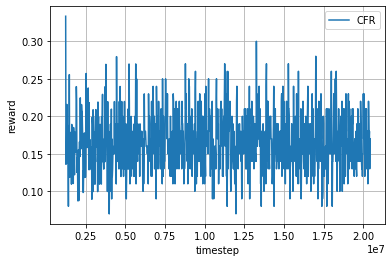

In [7]:
for episode in range(episode_num):
    agent.train()
    print('\rIteration {}'.format(episode), end='')
    # Evaluate the performance. Play with NFSP agents.
    if episode % evaluate_every == 0:
        agent.save() # Save model
        logger.log_performance(env.timestep, exploitability(eval_env_2, agent, 50))

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('CFR')